This notebook assesses the within-subject reliability of functional connectivity matrices 
created in connectivity.py (one for each session/subject, 12 sessions/subject).

Similarity measure: Pearson spatial correlation (?)
From Finn et al. 2015 Connectome Fingerprinting 
https://www.nature.com/articles/nn.4135

3 strategies:
- Session-by-session (compare similarity of all pairs of connectomes, do we see off-diagonal subject-specific structure?)
- Intra-class correlation coefficient
- Split-half (split each subject's data in half, average, and then compare. Somehow.)

NOTE: this notebook is...really hard to run. It needs a ton of RAM. So, I'm trying to run it on Sherlock but haven't been successful yet. Also, I'm currently working around the NaN values left by background voxels being correlated in the connectome creation step. Pandas df.corr() handles NaN values, whereas np.corrcoef() does not.

Author: Chris Iyer, updated 9/22/2023

### Load libraries and connectomes

In [1]:
import numpy as np
import glob
import seaborn as sns
sns.set(palette="colorblind")
import matplotlib.pyplot as plt
from pingouin import intraclass_corr
import pandas as pd
from joblib import Parallel, delayed

In [2]:
# load connectomes
def load_connectomes():

    data_dict = {}
    for sub in np.unique([f[f.find('sub'):f.find('sub')+7] for f in glob.glob('outputs/connectomes/*ses*')]):
        data_dict[sub] = {}
        for ses in np.unique([f[f.find('ses'):f.find('ses')+6] for f in glob.glob(f'outputs/connectomes/*{sub}*ses*')]):
            curr = np.load(glob.glob(f'outputs/connectomes/*{sub}_{ses}*')[0])
            data_dict[sub][ses] = {
                'connectome': curr, # save memory without this
                # 'connectome_flat': curr.flatten()
            }

    # connectomes_flat = []
    # for sub in data_dict.keys():
    #     for ses, data in data_dict[sub].items():
    #         connectomes_flat.append(data['connectome_flat'])
    
    return data_dict

def load_connectomes_flat(sub=''):

    connectomes_flat = pd.DataFrame() 
    # connectomes_flat = []
    subcount, sescount = (0,0)

    for sub in np.unique([f[f.find('sub'):f.find('sub')+7] for f in glob.glob(f'outputs/connectomes/{sub}*ses*')]):
        subcount +=1
        for ses in np.unique([f[f.find('ses'):f.find('ses')+6] for f in glob.glob(f'outputs/connectomes/*{sub}*ses*')]):
            sescount +=1

            connectomes_flat[sub+ses] = np.load(glob.glob(f'outputs/connectomes/*{sub}_{ses}*')[0]).flatten()
            # connectomes_flat.append( np.load(glob.glob(f'outputs/connectomes/*{sub}_{ses}*')[0]).flatten() )

    return connectomes_flat, subcount, int(sescount/subcount)

In [3]:
# data_dict, connectomes_flat = load_connectomes()
connectomes_flat, n_subjects, n_sessions = load_connectomes_flat()
connectomes_flat.shape

(52812800, 60)

### 1. Compare similarity session-by-session of all pairs of connectomes


Do we see off-diagonal subject-specific structure?

In [61]:
def get_correlation_matrix(connectomes_flat):
    # 60 sessions, 60x60 symmetric correlation matrix
    d = connectomes_flat.shape[1]
    matrix = np.zeros((d,d))
    
    for i in range(d):
        for j in range(d):
            if i <= j: # in the upper triangle
                print(i,j)
                matrix[i,j] = connectomes_flat.iloc[:,[i,j]].corr().iloc[0][1]

    
    return np.triu(matrix) + np.triu(matrix, k=1).T # copy the upper triangle onto the lower

In [6]:
# calculate correlation matrix of connectivity vectors
# similarity_matrix = get_correlation_matrix(connectomes_flat)
similarity_matrix = np.load('outputs/reliability/session_similarity_matrix.npy')

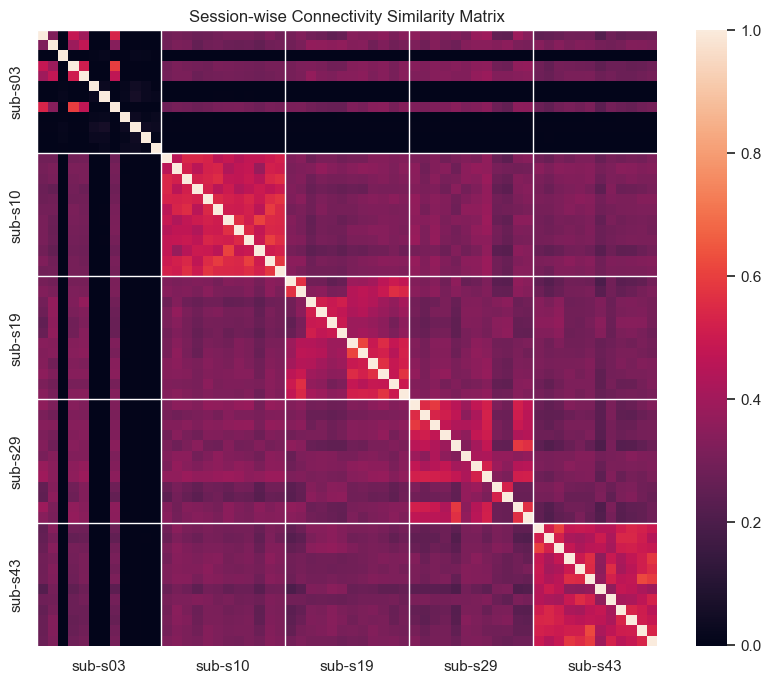

In [7]:
# plot the similarity matrix 
fig, ax = plt.subplots(1, 1, figsize=(10,8))

sns.heatmap(similarity_matrix, ax=ax)

# Add lines to box off every num_ses entries (each subject)
for i in range(0, similarity_matrix.shape[0], n_sessions):
    ax.axhline(i, color='white', linewidth=1)
    ax.axvline(i, color='white', linewidth=1)

xtick_labels = ['sub-s03', 'sub-s10', 'sub-s19', 'sub-s29', 'sub-s43']
xtick_positions = np.arange(n_sessions/2, similarity_matrix.shape[1], n_sessions)
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels)
ax.set_yticks(xtick_positions)
ax.set_yticklabels(xtick_labels)
ax.set_title("Session-wise Connectivity Similarity Matrix")
plt.show()

### 2. Intra-class Correlation Coefficient (NOT RUN)

In [5]:
data = np.array(connectomes_flat)
data_long = pd.DataFrame(data.flatten(), columns=['connectivity_values'])
data_long['subjects'] = np.repeat(range(n_subjects), n_sessions*data.shape[1]) 
data_long['sessions'] = np.tile(np.repeat(range(n_sessions), data.shape[1]), n_subjects)  # 12 sessions for each subject

icc = intraclass_corr(data=data_long, targets='subjects', raters='sessions', ratings='connectivity_values').set_index('Type')
print(icc.loc['ICC2'])

Description    Single random raters
ICC                        0.036539
F                          1.158656
df1                               4
df2                              12
pval                       0.376525
CI95%                 [-0.21, 0.69]
Name: ICC2, dtype: object


### 3. Split-half reliability (NOT RUN)


Procedure:
1. Split every subject's sessions randomly into 2 groups of 6 sessions
2. Average within a group (now we have 2 connectomes per subject)
3. Calculate the correlation of each to its within-subject pair
4. Calculate the correlation of each to all the others, and average
5. Iterate steps 1-4 1000 times and save all the values

*UPDATE*: I sure wish I could do this but it's just not computationally feasible. It takes hours to get a single correlation matrix, much less 1000 iterations of getting 4 of them. I'll look into possible solutions but since the simple correlation matrix of connectomes is promising, this might not be necessary.

In [6]:
n_iter = 1000
avg_within_sub_corr = []
avg_across_sub_corr = []

for i_iter in range(n_iter):

    # split data into halves and calculate the mean of the half
    split_dict = {} # for storing values during these calculations

    for sub in data_dict.keys():
        split_dict[sub] = {}
        rand_ses = list(np.random.permutation(list(data_dict[sub].keys())))
        group1data = []
        group2data = []

        for ses, data in data_dict[sub].items():
            if rand_ses.index(ses) > len(rand_ses)/2-1:
                # if in the second half of randomized list
                group1data.append(data['connectome_flat'])
            else:
                group2data.append(data['connectome_flat'])
        
        split_dict[sub]['group1_mean'] = np.mean(group1data, axis=0)
        split_dict[sub]['group2_mean'] = np.mean(group2data, axis=0)

    # iterate again and calculate correlation with each other group
    within_sub_corr = []
    across_sub_corr = []
    for sub in split_dict.keys():
        # save correlation of that sub's two halves
        within_sub_corr.append(np.corrcoef(split_dict[sub]['group1_mean'], split_dict[sub]['group2_mean']))

        # calculate correlation of each of those to all others 
        for sub_two in split_dict.keys():
            if sub_two != sub:
                across_sub_corr.append(np.corrcoef(split_dict[sub]['group1_mean'], split_dict[sub_two]['group1_mean']))
                across_sub_corr.append(np.corrcoef(split_dict[sub]['group1_mean'], split_dict[sub_two]['group2_mean']))
                across_sub_corr.append(np.corrcoef(split_dict[sub]['group2_mean'], split_dict[sub_two]['group1_mean']))
                across_sub_corr.append(np.corrcoef(split_dict[sub]['group2_mean'], split_dict[sub_two]['group2_mean']))

    avg_within_sub_corr.append(np.mean(within_sub_corr))
    avg_across_sub_corr.append(np.mean(across_sub_corr))

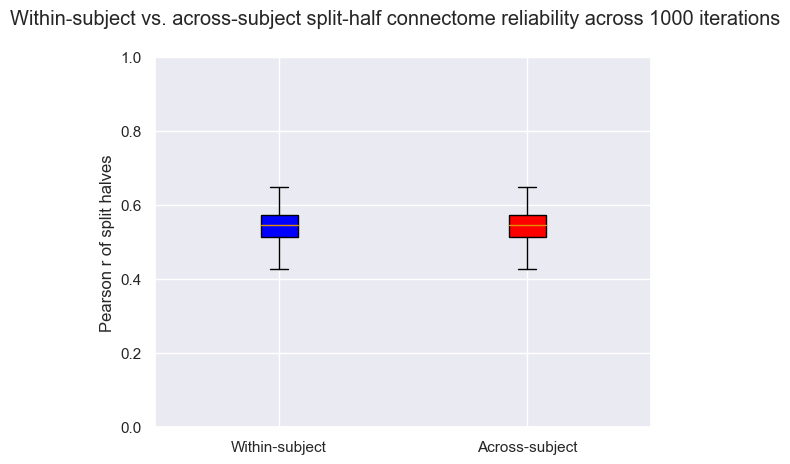

In [7]:
# plot the results
fig, ax = plt.subplots(1,1)
fig.suptitle('Within-subject vs. across-subject split-half connectome reliability across 1000 iterations')
ax.boxplot(avg_within_sub_corr, positions=[1], patch_artist=True, boxprops=dict(facecolor='blue'), labels=['Within-subject'])
ax.boxplot(avg_within_sub_corr, positions=[2], patch_artist=True, boxprops=dict(facecolor='red'), labels=['Across-subject'])
ax.set_ylabel('Pearson r of split halves')
ax.set_ylim(0,1)
plt.show()

### 4. Before averaging, assess dropout


Here was my code to assess if we had too much dropout in voxels to trust averaging across sessions
(Some sessions lacked data from certain voxels, and we wanted to be sure the averages weren't driven by fewer than half of the sessions' worth of data).

In [ ]:
files = glob.glob('/oak/stanford/groups/russpold/data/network_grant/discovery_BIDS_21.0.1/derivatives/glm_data_MNI/**/*rest*optcomDenoised*.nii.gz', recursive = True)
sublist = np.unique([f[f.find('sub'):f.find('sub')+7] for f in files])

def get_missing_voxels(within_sub_missing_allowed=11, mask=''):
    """
    within_sub_missing_allowed = 11: if a voxel has no signal in all 12 of one subject's sessions, exclude it for everyone (most liberal)
    within_sub_missing_allowed = 6: if a voxel has no signal in 6 or more of one subject's sessions, exclude it
    within_sub_missing_allowed = 0: if a voxel has no signal in a single session, exclude it for everyone (most conservative)
    """

    mask = mask.get_fdata()
    master_missing_img = np.zeros((97,115,97)) # keeps track of which voxels have missing values

    for sub in sublist:
        subfiles = [f for f in files if sub in f]
        
        def one_session(f):
            session_zeros = math_img('img == 0', img = mean_img(nib.load(f))).get_fdata()
            return session_zeros * mask
        sessions = Parallel(n_jobs = 12, backend='threading')(
            delayed(one_session)(f) for f in subfiles
        )

        sub_missing_counts = sum(sessions)
        master_missing_img += (sub_missing_counts > within_sub_missing_allowed).astype(int) 

    master_missing_img = (master_missing_img > 1).astype(int) # back to 1s and 0s

    return master_missing_img

_, _, parcel_mask = get_parcellation(schaefer_n_rois = 400, resample_target = nib.load(files[0]))
gm_mask = math_img('img >= 0.5', img=nib.load('data/templates/tpl-MNI152NLin2009cAsym_res-02_label-GM_probseg.nii.gz'))
double_mask = math_img('img1 * img2', img1 = gm_mask, img2 = parcel_mask) # this will exclude the cerebellum (and probably other voxels)

count = 0
for missing_num in [0,6,11]:
    for mask in ['gm', 'double']:
        if mask == 'gm':
            out = get_missing_voxels(within_sub_missing_allowed = missing_num, mask = gm_mask)
            count += 1
        else: 
            out = get_missing_voxels(within_sub_missing_allowed = missing_num, mask = double_mask)
            count += 1
        print(f'count done: {count}, saving now')
        np.save(f'/scratch/users/csiyer/voxel_test/missing-{missing_num}_mask-{mask}.npy', out)



### 5. Finally, average connectomes within subject and re-save (if they are reliable!)
This code was carried out by connectome_avg.py when running the whole pipeline in one shot.

In [5]:
data_dict = load_connectomes()
for sub in data_dict.keys():
    connectome_avg = np.nanmean([data_dict[sub][ses]['connectome'] for ses in data_dict[sub].keys()], axis=0)
    np.save(f"outputs/connectomes/{sub}_connectome_avg.npy", connectome_avg)